In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('../train.csv')

In [3]:
label_names = ['None', 'Lead', 'Position', 'Evidence', 'Claim',
               'Concluding Statement', 'Counterclaim', 'Rebuttal']

In [3]:
per_id_entity_counts = data.groupby('id').apply(lambda x: x.discourse_type.value_counts()).unstack().fillna(0)

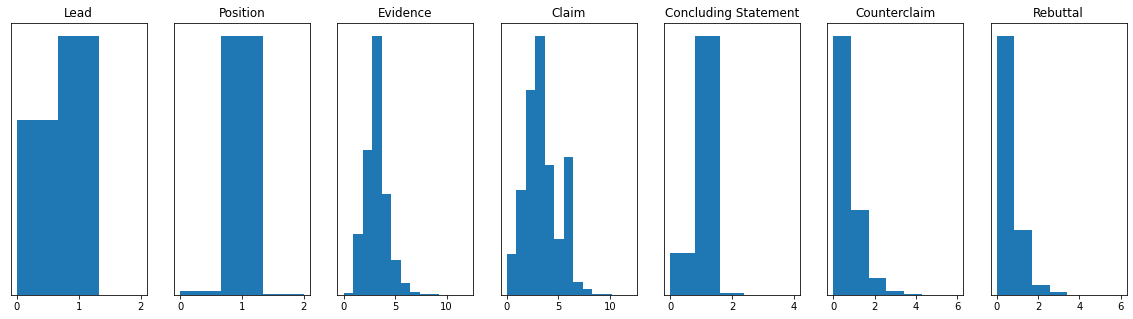

In [7]:
entity_types = per_id_entity_counts.columns
fig, axs = plt.subplots(1, len(entity_types), figsize=(20, 5))
for ix in range(len(label_names) - 1):
    axs[ix].hist(per_id_entity_counts[label_names[ix + 1]], int(per_id_entity_counts[label_names[ix + 1]].max() + 1))
    axs[ix].set_title(label_names[ix + 1])
    axs[ix].set_yticks([])

In [8]:
def num_words_in_target(x):
    chunks = x.split()
    return int(chunks[-1]) - int(chunks[0]) + 1

In [9]:
data['num_target_words'] = data.predictionstring.map(num_words_in_target)

In [10]:
num_words_per_entity = data.groupby('discourse_type').apply(lambda x: x.num_target_words.value_counts()).unstack().fillna(0)

In [11]:
more_than_299_words = num_words_per_entity[num_words_per_entity.columns[num_words_per_entity.columns >= 300]].values.sum(-1)

In [12]:
num_words_per_entity = num_words_per_entity[num_words_per_entity.columns[num_words_per_entity.columns < 300]]
num_words_per_entity[300] = more_than_299_words

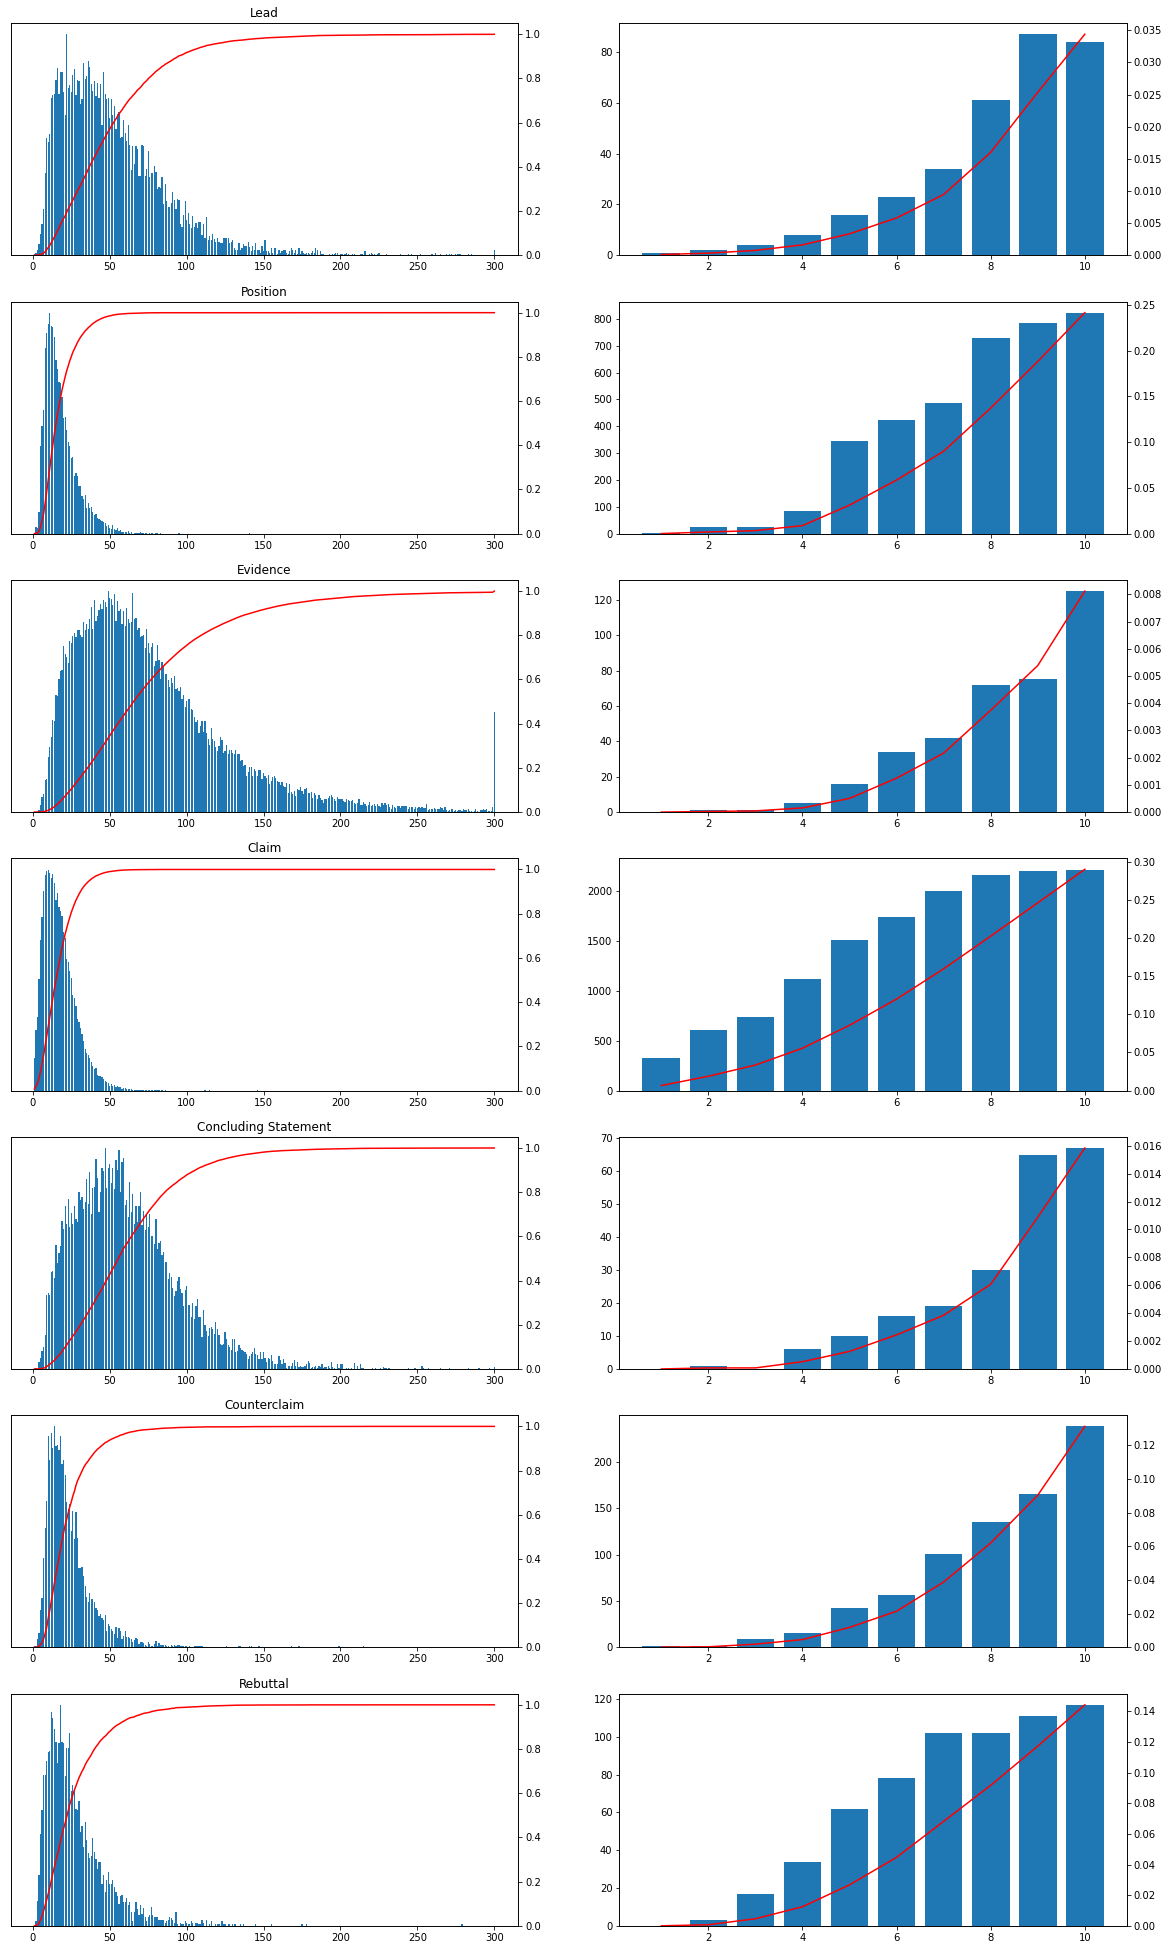

In [14]:
entity_types = per_id_entity_counts.columns
fig, axs = plt.subplots(len(entity_types), 2, figsize=(20, 5 * len(entity_types)))
for ix in range(len(label_names) - 1):
    word_counts = num_words_per_entity.loc[label_names[ix + 1]]
    total_ents = word_counts.sum()
    cumulative = word_counts.cumsum() / total_ents
    axs[ix, 0].bar(range(1, 301), word_counts)
    extra_ax = axs[ix, 0].twinx()
    extra_ax.plot(cumulative, c='r')
    extra_ax.set_ylim(bottom=0)
    axs[ix, 1].bar(range(1, 11), word_counts[:10])
    extra_ax = axs[ix, 1].twinx()
    extra_ax.plot(cumulative[:10], c='r')
    extra_ax.set_ylim(bottom=0)
    axs[ix, 0].set_title(label_names[ix + 1])
for ax in axs[:, 0]:
    ax.set_yticks([])

# start from here

In [1]:
import dill as pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
with open('../data_splits.pickle', 'rb') as f:
    data_splits = pickle.load(f)
val_bounds = np.cumsum([0] + [len(data_splits[0][250]['normed'][fold_ix]) for fold_ix in range(5)])

In [76]:
def extract_entities(ps, n, min_lens=(2, 2, 5, 2, 4, 3, 2), score_filter=False):
    cat_ps = ps.argmax(-1)
    all_entities = {}
    current_cat = None
    current_start = None
    seq_len = ps.shape[0]
    for ix in range(n):
    # for ix in range(seq_len - n, seq_len - 2):
        if cat_ps[ix] % 2 == 1:
            if current_cat is not None:
                if current_cat not in all_entities:
                    all_entities[current_cat] = []
                all_entities[current_cat].append((current_start, ix - 1))
            current_cat = (cat_ps[ix] + 1) // 2
            current_start = ix        
        elif cat_ps[ix] == 0:
            if current_cat is not None:
                if current_cat not in all_entities:
                    all_entities[current_cat] = []
                all_entities[current_cat].append((current_start, ix - 1))
            current_cat = None
        elif current_cat is not None and cat_ps[ix] != current_cat * 2:
            if current_cat not in all_entities:
                all_entities[current_cat] = []
            all_entities[current_cat].append((current_start, ix - 1))
            current_cat = None
    if current_cat is not None:
        if current_cat not in all_entities:
            all_entities[current_cat] = []
        all_entities[current_cat].append((current_start, ix))

    
    score_thresholds = [None, -1.55, -1.3, -1.13, -1.4, -1.2, -3.5, -3.5]  ## modify these after visually finding thresholds
    for cat_ix, min_len in zip(range(1, 8), min_lens):
        if cat_ix in all_entities:
            possible_entities = [x for x in all_entities[cat_ix] if x[1] - x[0] + 1 >= min_len]
            if score_filter:
                possible_entities = [x for x in possible_entities if calc_entity_score(x, ps, cat_ix) > score_thresholds[cat_ix]]
            if cat_ix in (1, 2,  5):
                if len(possible_entities) > 1:
                    max_score = -9999
                    for x in possible_entities:
                        entity_score = calc_entity_score(x, ps, cat_ix)
                        if entity_score > max_score:
                            max_score = entity_score
                            biggest_entity = x
                    
                    possible_entities = [biggest_entity]
            all_entities[cat_ix] = possible_entities
        
    return all_entities

#5, 4, 17, 2, 8, 7, 7

#6, 5, 17, 2, 7, 7, 5
#2, 2, 5, 2, 4, 3, 2
def process_sample(raw_ps, index_map, bounds, gt_spans, num_tokens, match_stats, min_lens=[2, 2, 5, 2, 4, 3, 2], score_filter=False):
    
    matched_ps = {cat_ix: [] for cat_ix in range(1, 8)}
    mismatched_ps = {cat_ix: [] for cat_ix in range(1, 8)}
    #bounds[num_tokens - 2, 1] = min(len(index_map) - 1, bounds[num_tokens - 2, 1])
    token_level_entities = extract_entities(raw_ps, num_tokens, min_lens, score_filter)
    predicted_spans = {x: [map_span_to_word_indices(span, index_map, bounds) for span in y] for x, y in token_level_entities.items()}

    
    for cat_ix in range(1, 8):
        
        pspans = predicted_spans.get(cat_ix, [])
        gspans = gt_spans.get(cat_ix, [])
        tspans = token_level_entities.get(cat_ix, [])
        if not len(pspans) or not len(gspans):
            match_stats[cat_ix]['fn'] += len(gspans)
            match_stats[cat_ix]['fp'] += len(pspans)
        else:
            all_overlaps = np.zeros((len(pspans), len(gspans)))
            for x1 in range(len(pspans)):
                pspan = pspans[x1]
                for x2 in range(len(gspans)):
                    gspan = gspans[x2]
                    start_ix = max(pspan[0], gspan[0])
                    end_ix = min(pspan[1], gspan[1])
                    overlap = max(0, end_ix - start_ix + 1)
                    if overlap > 0:
                        o1 = overlap / (pspan[1] - pspan[0] + 1)
                        o2 = overlap / (gspan[1] - gspan[0] + 1)
                        if min(o1, o2) >= .5:
                            all_overlaps[x1, x2] = max(o1, o2)
            unused_p_ix = set(range(len(pspans)))
            unused_g_ix = set(range(len(gspans)))
            col_size = len(pspans)
            row_size = len(gspans)
            for ix in np.argsort(all_overlaps.ravel())[::-1]:
                if not len(unused_g_ix) or not len(unused_p_ix) or all_overlaps.ravel()[ix] == 0:
                    match_stats[cat_ix]['fp'] += len(unused_p_ix)
                    match_stats[cat_ix]['fn'] += len(unused_g_ix)
                    mismatched_ps[cat_ix].extend((tspans[x] for x in unused_p_ix))
                    break
                p_ix = ix // row_size
                g_ix = ix % row_size
                if p_ix not in unused_p_ix or g_ix not in unused_g_ix:
                    continue
                match_stats[cat_ix]['tp'] += 1
                unused_g_ix.remove(g_ix)
                unused_p_ix.remove(p_ix)
                matched_ps[cat_ix].append(tspans[p_ix])
    return match_stats, matched_ps, mismatched_ps

def map_span_to_word_indices(span, index_map, bounds):
    return (index_map[bounds[span[0], 0]], index_map[bounds[span[1], 1] - 1])

def split_predstring(x):
    vals = x.split()
    return int(vals[0]), int(vals[-1])

In [77]:
def make_gt_dict(df):
    gt_dict = {}
    for cat_ix in range(1, 8):
        cat_name = label_names[cat_ix]
        cat_entities = df.loc[df.discourse_type==cat_name]
        if len(cat_entities):
            gt_dict[cat_ix] = [(x[0], x[1]) for x in cat_entities.predictionstring.map(split_predstring)]
    return gt_dict

In [24]:
def f1s(stats):
    f1s = np.zeros(8)
    f1s[1:] = stats[:, 0] / (1e-7 + stats[:, 0] + stats[:, 1:].mean(-1))
    f1s[0] = f1s[1:].mean()
    return f1s

In [25]:
def calc_entity_score(span, ps, c):
    s, e = span
    score = (ps[s, c * 2 - 1] + ps[s + 1: e + 1, c * 2].sum())/(e - s + 1)
    return score

In [26]:
with open('../gt_dicts.pickle', 'rb') as f:
    gt_dicts = pickle.load(f)

In [27]:
from tqdm import tqdm

## run up to here

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:26<00:00,  8.61s/it]


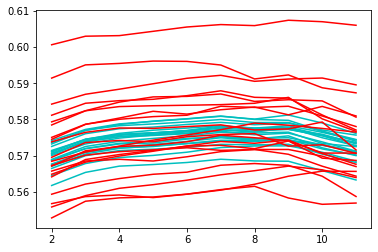

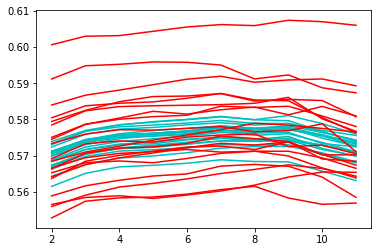

In [75]:
min_lens = [2, 2, 5, 2, 4, 3, 2]

train_rands = []
val_rands = []
for _ in range(20):
    shuffle_index = np.arange(0, len(all_outs))
    for _ in range(3):
        np.random.shuffle(shuffle_index)
    train_rands.append(shuffle_index[:int(len(shuffle_index) * .8)])
    val_rands.append(shuffle_index[int(len(shuffle_index) * .8):])

min_param_value = 2
num_to_check = 10
param_traces = np.zeros((20, 2, num_to_check))
param_ix = 5
for filter_with_scores in (True, False):
    for x in tqdm(range(min_param_value, min_param_value + num_to_check)):
        min_lens[param_ix] = x
        all_matched_ps = {}
        all_mismatched_ps = {}
        all_stats = np.zeros((val_bounds[-1], 7, 3))
        text_ix = 0
        for fold_ix in range(5):
            start_ix = val_bounds[fold_ix]
            end_ix = val_bounds[fold_ix + 1]
            sample_stats = {ix:  {'fp': 0, 'fn': 0, 'tp': 0} for ix in range(1, 8)}
            fold_ps = all_outs[start_ix:end_ix]
            fold_bounds = all_bounds[start_ix:end_ix]
            fold_token_nums = all_token_nums[start_ix:end_ix]
            fold_word_indices = all_word_indices[start_ix:end_ix]
            fold_sample_ids = all_sample_ids[start_ix:end_ix]
            for sample_ix in range(len(fold_ps)):
                sample_stats, sample_matched, sample_mismatched  = process_sample(fold_ps[sample_ix],
                                                                                fold_word_indices[sample_ix], 
                                                                                fold_bounds[sample_ix],
                                                                                gt_dicts[fold_sample_ids[sample_ix]],
                                                                                fold_token_nums[sample_ix],
                                                                               {ix:  {'fp': 0, 'fn': 0, 'tp': 0}
                                                                                for ix in range(1, 8)}, min_lens, score_filter=filter_with_scores)
                for cat_ix in range(7):
                    all_stats[text_ix, cat_ix] = [sample_stats[cat_ix + 1][x] for x in ('tp', 'fp', 'fn')]
                all_matched_ps[fold_sample_ids[sample_ix]] = sample_matched
                all_mismatched_ps[fold_sample_ids[sample_ix]] = sample_mismatched
                text_ix += 1
        for random_ix in range(20):
            param_traces[random_ix, 0, x - min_param_value] = f1s(all_stats[train_rands[random_ix]].sum(0))[param_ix + 1]
            param_traces[random_ix, 1, x - min_param_value] = f1s(all_stats[val_rands[random_ix]].sum(0))[param_ix + 1]
    plt.figure()
    for r in range(20):
        plt.plot(range(min_param_value, min_param_value + num_to_check), param_traces[r, 0], c='c')
    for r in range(20):
        plt.plot(range(min_param_value, min_param_value + num_to_check), param_traces[r, 1], c='r')

In [ ]:
3, 3, 17, 2, 6, 7, 7

## continue from here

In [50]:
list_of_dir_names = ['debertav1_rce01']

In [36]:
def merge_ps(logits_a, logits_b, bounds_a, bounds_b):
    a = bounds_a
    b = bounds_b
    mapping_a = []
    mapping_b = []
    new_bounds = []
    apos = 0
    bpos = 0
    a_s, a_e = a[apos]
    b_s, b_e = b[bpos]
    current_start = 0
    while True:
        if a_e == b_e:
            if apos == len(a) - 1 or bpos == len(b) - 1:
                break
            new_bounds.append((current_start, b_e))
            mapping_a.append(apos)
            mapping_b.append(bpos)
            next_a_s, next_b_s = a[apos + 1][0], b[bpos + 1][0]
            if next_a_s < next_b_s:
                apos += 1
                a_s, a_e = a[apos]
                current_start = a_s
            elif next_b_s < next_a_s:
                bpos += 1
                b_s, b_e = b[bpos]
                current_start = b_s
            else:
                apos += 1
                bpos += 1
                a_s, a_e = a[apos]
                b_s, b_e = b[bpos]
                current_start = a_s
        elif a_e < b_e:
            new_bounds.append((current_start, a_e))
            mapping_a.append(apos)
            mapping_b.append(bpos)
            apos += 1
            a_s, a_e = a[apos]
            current_start = a_s
        else:
            new_bounds.append((current_start, b_e))
            mapping_a.append(apos)
            mapping_b.append(bpos)
            bpos += 1
            b_s, b_e = b[bpos]
            current_start = b_s
    
    return logits_a[mapping_a] + logits_b[mapping_b], np.array(new_bounds)


In [86]:
arrays = []

for array_name in 'all_outs, all_bounds, all_token_nums, all_word_indices, all_sample_ids'.split(', '):
    arrays.append(np.load(f'oof_ps/{list_of_dir_names[0]}/{array_name}.npy', allow_pickle=True))
all_outs, all_bounds, all_token_nums, all_word_indices, all_sample_ids = arrays

#all_outs += np.load(f'oof_ps/{list_of_dir_names[1]}/all_outs.npy')

# for oof_dir_name in list_of_dir_names[1:]:
#         arrays = []
#         for array_name in 'all_outs, all_bounds, all_token_nums'.split(', '):
#             arrays.append(np.load(f'oof_ps/{oof_dir_name}/{array_name}.npy', allow_pickle=True))
#         new_outs, new_bounds, new_token_nums = arrays
#         merged_outs = []
#         merged_bounds = []
#         merged_token_nums = []
#         for sample_ix in range(len(new_outs)):
#             logits, bounds = merge_ps(all_outs[sample_ix][:all_token_nums[sample_ix]],
#                                       new_outs[sample_ix][:new_token_nums[sample_ix]],
#                                       all_bounds[sample_ix][:all_token_nums[sample_ix]],
#                                       new_bounds[sample_ix][:new_token_nums[sample_ix]])
#             merged_outs.append(logits)
#             merged_bounds.append(bounds)
#             merged_token_nums.append(len(logits))
#         all_outs = merged_outs
#         all_bounds = merged_bounds
#         all_token_nums = merged_token_nums


all_matched_ps = {}
all_mismatched_ps = {}
    
all_stats = np.zeros((val_bounds[-1], 7, 3))
text_ix = 0
for fold_ix in range(5):
    start_ix = val_bounds[fold_ix]
    end_ix = val_bounds[fold_ix + 1]
    sample_stats = {ix:  {'fp': 0, 'fn': 0, 'tp': 0} for ix in range(1, 8)}
    fold_ps = all_outs[start_ix:end_ix]
    fold_bounds = all_bounds[start_ix:end_ix]
    fold_token_nums = all_token_nums[start_ix:end_ix]
    fold_word_indices = all_word_indices[start_ix:end_ix]
    fold_sample_ids = all_sample_ids[start_ix:end_ix]
    for sample_ix in range(len(fold_ps)):
        sample_stats, sample_matched, sample_mismatched  = process_sample(fold_ps[sample_ix],
                                                                        fold_word_indices[sample_ix], 
                                                                        fold_bounds[sample_ix],
                                                                        gt_dicts[fold_sample_ids[sample_ix]],
                                                                        fold_token_nums[sample_ix],
                                                                       {ix:  {'fp': 0, 'fn': 0, 'tp': 0}
                                                                        for ix in range(1, 8)}, score_filter=False)
        for cat_ix in range(7):
            all_stats[text_ix, cat_ix] = [sample_stats[cat_ix + 1][x] for x in ('tp', 'fp', 'fn')]
        all_matched_ps[fold_sample_ids[sample_ix]] = sample_matched
        all_mismatched_ps[fold_sample_ids[sample_ix]] = sample_mismatched
        text_ix += 1
    print(f'fold {fold_ix} f1s: {f1s(all_stats[start_ix:end_ix].sum(0))}')


fold 0 f1s: [0.70013097 0.84227213 0.71789787 0.75181099 0.65835814 0.86552478
 0.58010118 0.48495173]
fold 1 f1s: [0.69895203 0.82399162 0.7278481  0.7465036  0.65272471 0.8597786
 0.57779612 0.50402145]
fold 2 f1s: [0.70153008 0.83526927 0.72781556 0.74612968 0.65893691 0.8556701
 0.5877012  0.49918787]
fold 3 f1s: [0.6950083  0.83697389 0.72264972 0.75169236 0.66134088 0.86698777
 0.55574183 0.46967167]
fold 4 f1s: [0.7073867  0.84148623 0.73837892 0.7488866  0.66713745 0.859317
 0.58208315 0.51441753]


In [87]:
def shuffle(scores, labels, score_ix_to_sample_ix):
    shuffle_index = np.arange(len(all_outs))
    for _ in range(3):
        np.random.shuffle(shuffle_index)
    
    
    return scores[shuffle_index], labels[shuffle_index], shuffle_index

In [88]:
def sort_(scores, labels):
    sort_index = np.argsort(scores)
    return scores[sort_index], labels[sort_index]

In [89]:
def f1(tp, fp, fn):
    return tp / (1e-7 + tp + .5 * (fp + fn))

In [90]:
def evaluate_thresholds(sorted_labels, tp, fp, fn):
    scores = []
    base_f1 = (f1(tp, fp, fn))
    for ix in range(len(sorted_labels) - 1):
        if sorted_labels[ix] == 0:
            fp -= 1
        else:
            tp -= 1
            fn += 1
        scores.append(f1(tp, fp, fn))
        if scores[-1] < base_f1 - .01:
            break
    return scores

In [91]:
def validate_thresholds(sorted_scores, sorted_labels, tp, fp, fn, thresholds):
    current_threshold = thresholds[0]
    pointer = 0
    val_scores = []
    for ix in range(len(sorted_scores)):
        if sorted_labels[ix] == 0:
            fp -= 1
        else:
            tp -= 1
            fn += 1
        if sorted_scores[ix] >= current_threshold:
            score = f1(tp, fp, fn)
            while sorted_scores[ix] >= current_threshold:
                val_scores.append(score)
                pointer += 1
                if pointer == len(thresholds):
                    break
                current_threshold = thresholds[pointer]
            if pointer == len(thresholds):
                break
                
    return val_scores

In [92]:
label_names = ['None', 'Lead', 'Position', 'Evidence', 'Claim',
               'Concluding Statement', 'Counterclaim', 'Rebuttal']

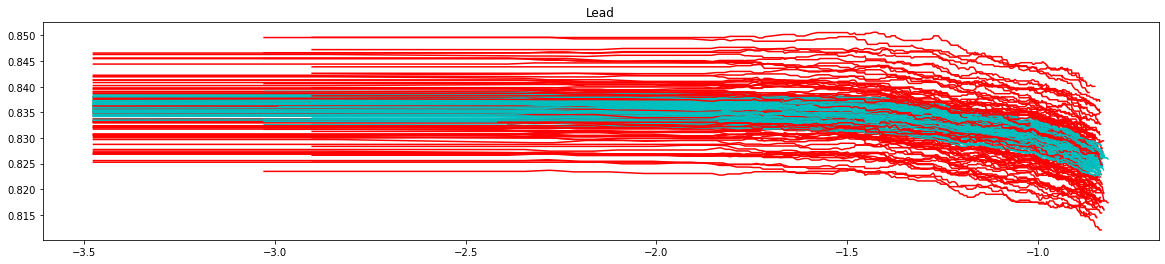

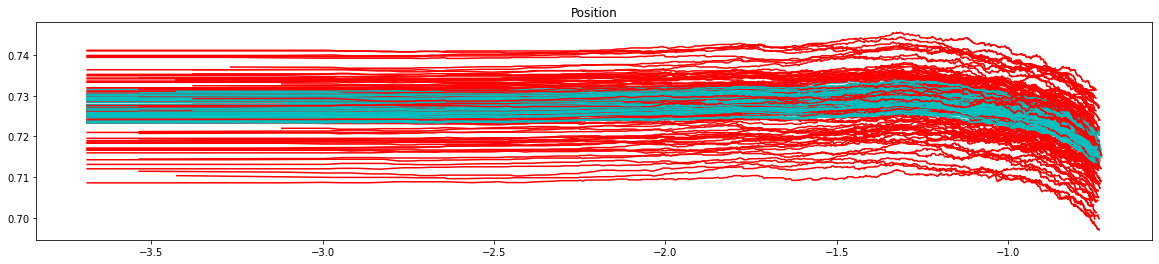

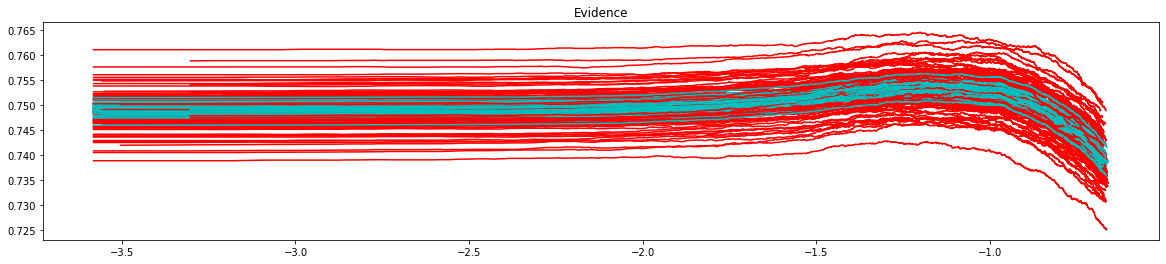

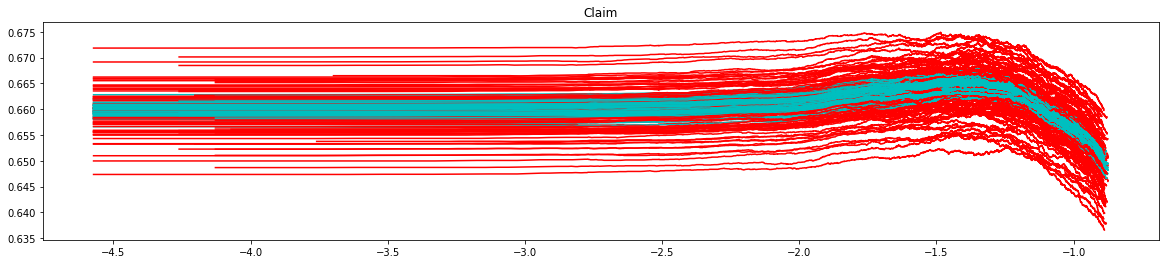

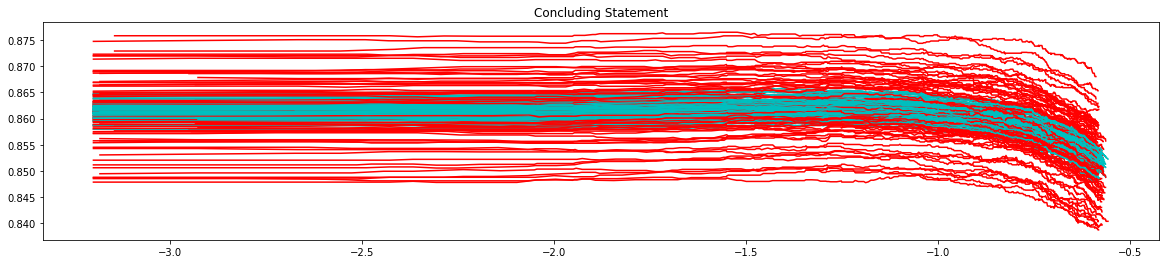

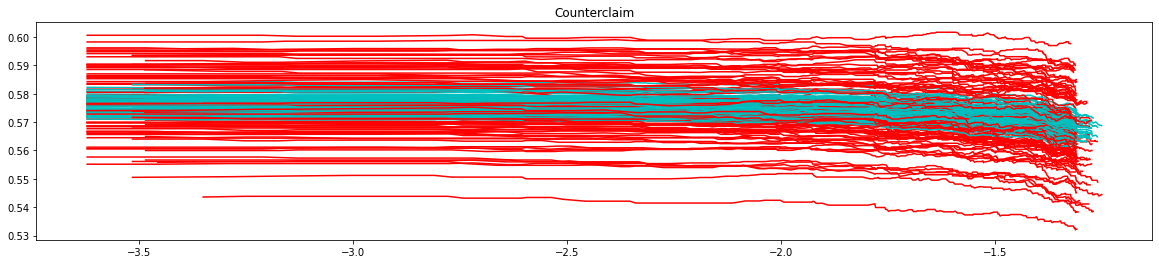

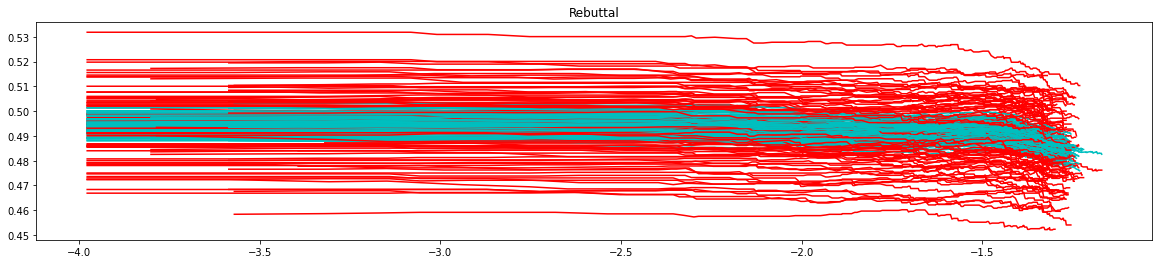

In [93]:
match_scores = {x: [] for x in range(1, 8)}
mismatch_scores = {x: [] for x in range(1, 8)}
    
for c in range(1, 8):
    samples = []
    for r in range(20):
        shuffle_index = np.arange(len(all_outs))
        for _ in range(3):
            np.random.shuffle(shuffle_index)
            
        fold_indices = [shuffle_index[x::5] for x in range(5)]
        
        fold_scores = [[] for _ in range(5)]
        fold_labels = [[] for _ in range(5)]
        for f in range(5):
            for sample_ix in fold_indices[f]:
                sample_id = all_sample_ids[sample_ix]
                for span in all_mismatched_ps[sample_id][c]:
                    s, e = span
                    fold_scores[f].append((all_outs[sample_ix][s, c * 2 - 1] 
                                        + all_outs[sample_ix][s + 1: e + 1, c * 2].sum())/(e - s + 1))
                    fold_labels[f].append(0)
                for span in all_matched_ps[sample_id][c]:
                    s, e = span
                    fold_scores[f].append((all_outs[sample_ix][s, c * 2 - 1] 
                                        + all_outs[sample_ix][s + 1: e + 1, c * 2].sum())/(e - s + 1))
                    fold_labels[f].append(1)
                    
        fold_scores = [np.array(x) for x in fold_scores]
        fold_labels = [np.array(x) for x in fold_labels]
                    
        fold_stats = [all_stats[x, c - 1] for x in fold_indices]
        
        train_score_datasets = [np.concatenate([fold_scores[f] for f in range(5) if f != val_fold]) 
                                for val_fold in range(5)]
        train_label_datasets = [np.concatenate([fold_labels[f] for f in range(5) if f != val_fold]) 
                                for val_fold in range(5)]
        train_stats_datasets = [np.concatenate([fold_stats[f] for f in range(5) if f != val_fold]).sum(0)
                                for val_fold in range(5)]
        
        val_score_datasets = fold_scores
        val_label_datasets = fold_labels
        val_stats_datasets = [x.sum(0) for x in fold_stats]
        
        
        for f in range(5):
            f_scores, f_labels = sort_(train_score_datasets[f], train_label_datasets[f])
            val_scores, val_labels = sort_(val_score_datasets[f], val_label_datasets[f])
            f_thresholds = (f_scores[:-1] + f_scores[1:]) * .5
            f_stats = train_stats_datasets[f]
            val_stats = val_stats_datasets[f]
            
            f_f1s = evaluate_thresholds(f_labels, *f_stats)
            val_f1s = validate_thresholds(val_scores, val_labels, *val_stats, f_thresholds[:len(f_f1s)])
            samples.append((f_thresholds[:len(f_f1s)], f_f1s, val_f1s))
    
    plt.figure(figsize=(20, 4))
    for x in samples:
        plt.plot(x[0], x[1], c='c')
        plt.plot(x[0], x[2], c='r')
    plt.title(label_names[c])
    

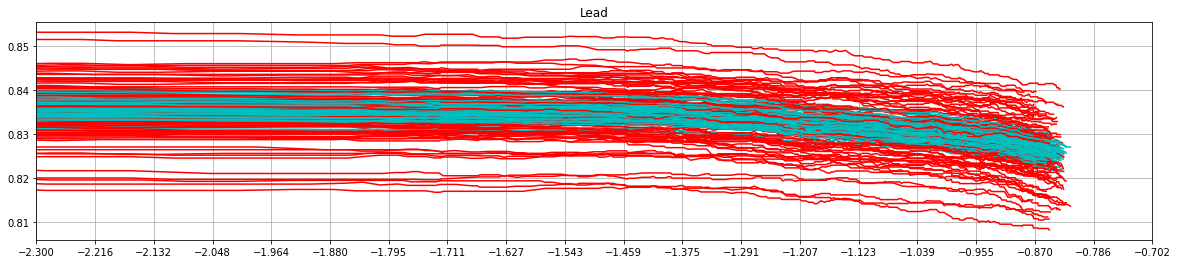

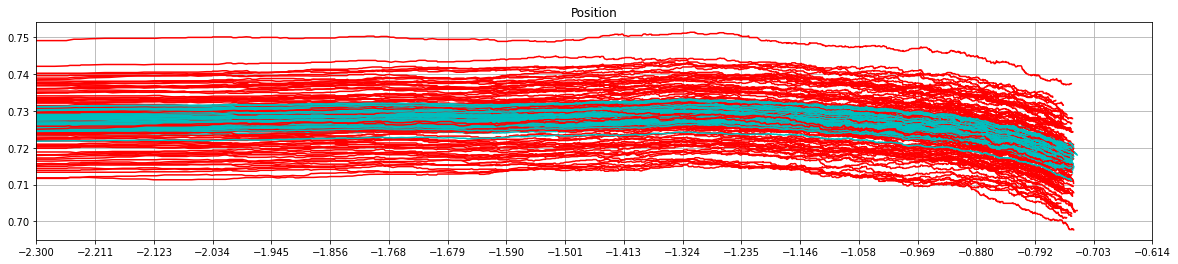

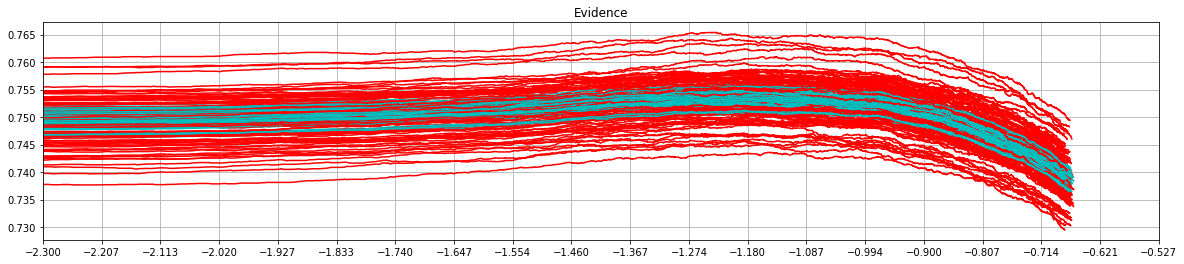

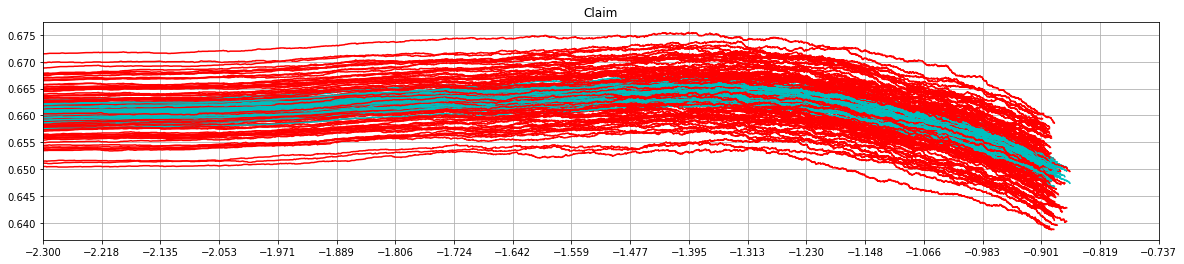

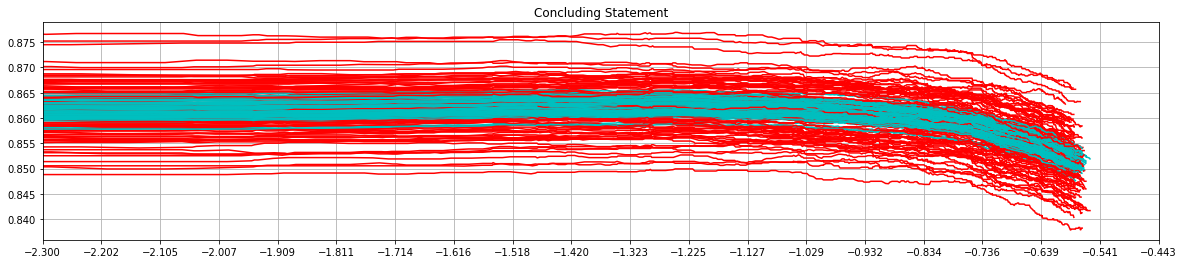

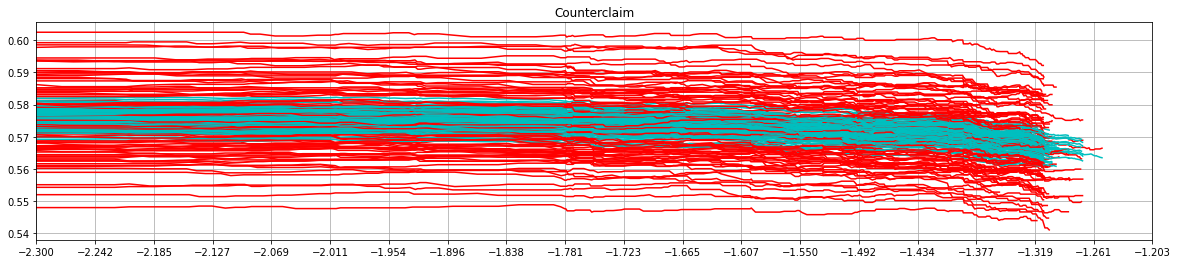

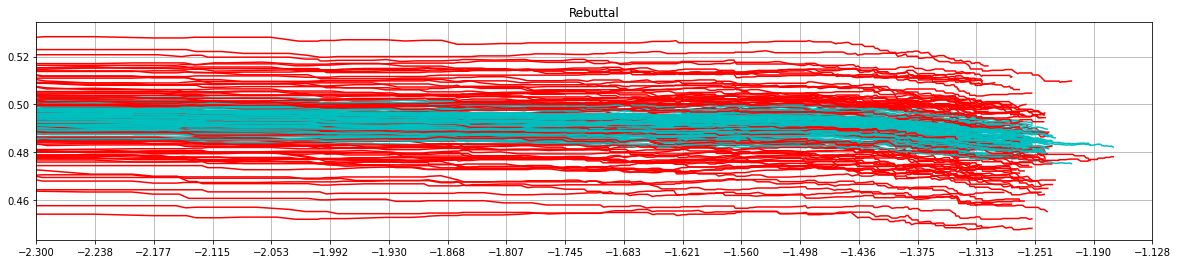

In [94]:
match_scores = {x: [] for x in range(1, 8)}
mismatch_scores = {x: [] for x in range(1, 8)}
    
for c in range(1, 8):
    samples = []
    for r in range(20):
        shuffle_index = np.arange(len(all_outs))
        for _ in range(3):
            np.random.shuffle(shuffle_index)
            
        fold_indices = [shuffle_index[x::5] for x in range(5)]
        
        fold_scores = [[] for _ in range(5)]
        fold_labels = [[] for _ in range(5)]
        for f in range(5):
            for sample_ix in fold_indices[f]:
                sample_id = all_sample_ids[sample_ix]
                for span in all_mismatched_ps[sample_id][c]:
                    s, e = span
                    fold_scores[f].append((all_outs[sample_ix][s, c * 2 - 1] 
                                        + all_outs[sample_ix][s + 1: e + 1, c * 2].sum())/(e - s + 1))
                    fold_labels[f].append(0)
                for span in all_matched_ps[sample_id][c]:
                    s, e = span
                    fold_scores[f].append((all_outs[sample_ix][s, c * 2 - 1] 
                                        + all_outs[sample_ix][s + 1: e + 1, c * 2].sum())/(e - s + 1))
                    fold_labels[f].append(1)
                    
        fold_scores = [np.array(x) for x in fold_scores]
        fold_labels = [np.array(x) for x in fold_labels]
                    
        fold_stats = [all_stats[x, c - 1] for x in fold_indices]
        
        train_score_datasets = [np.concatenate([fold_scores[f] for f in range(5) if f != val_fold]) 
                                for val_fold in range(5)]
        train_label_datasets = [np.concatenate([fold_labels[f] for f in range(5) if f != val_fold]) 
                                for val_fold in range(5)]
        train_stats_datasets = [np.concatenate([fold_stats[f] for f in range(5) if f != val_fold]).sum(0)
                                for val_fold in range(5)]
        
        val_score_datasets = fold_scores
        val_label_datasets = fold_labels
        val_stats_datasets = [x.sum(0) for x in fold_stats]
        
        
        for f in range(5):
            f_scores, f_labels = sort_(train_score_datasets[f], train_label_datasets[f])
            val_scores, val_labels = sort_(val_score_datasets[f], val_label_datasets[f])
            f_thresholds = (f_scores[:-1] + f_scores[1:]) * .5
            f_stats = train_stats_datasets[f]
            val_stats = val_stats_datasets[f]
            
            f_f1s = evaluate_thresholds(f_labels, *f_stats)
            val_f1s = validate_thresholds(val_scores, val_labels, *val_stats, f_thresholds[:len(f_f1s)])
            samples.append((f_thresholds[:len(f_f1s)], f_f1s, val_f1s))
    
    plt.figure(figsize=(20, 4))
    for x in samples:
        plt.plot(x[0], x[1], c='c')
        plt.plot(x[0], x[2], c='r')
        l, r = plt.xlim(left=-2.3) ############################################### here left bound to zoom in
        plt.xticks(np.linspace(l, r, 20))
        plt.grid('on')
    plt.title(label_names[c])
    
    -1.71, -1.3, -1.15, -1.35, -1.5, -3.5, -3.5

In [ ]:
# visually find thresholds from above plots

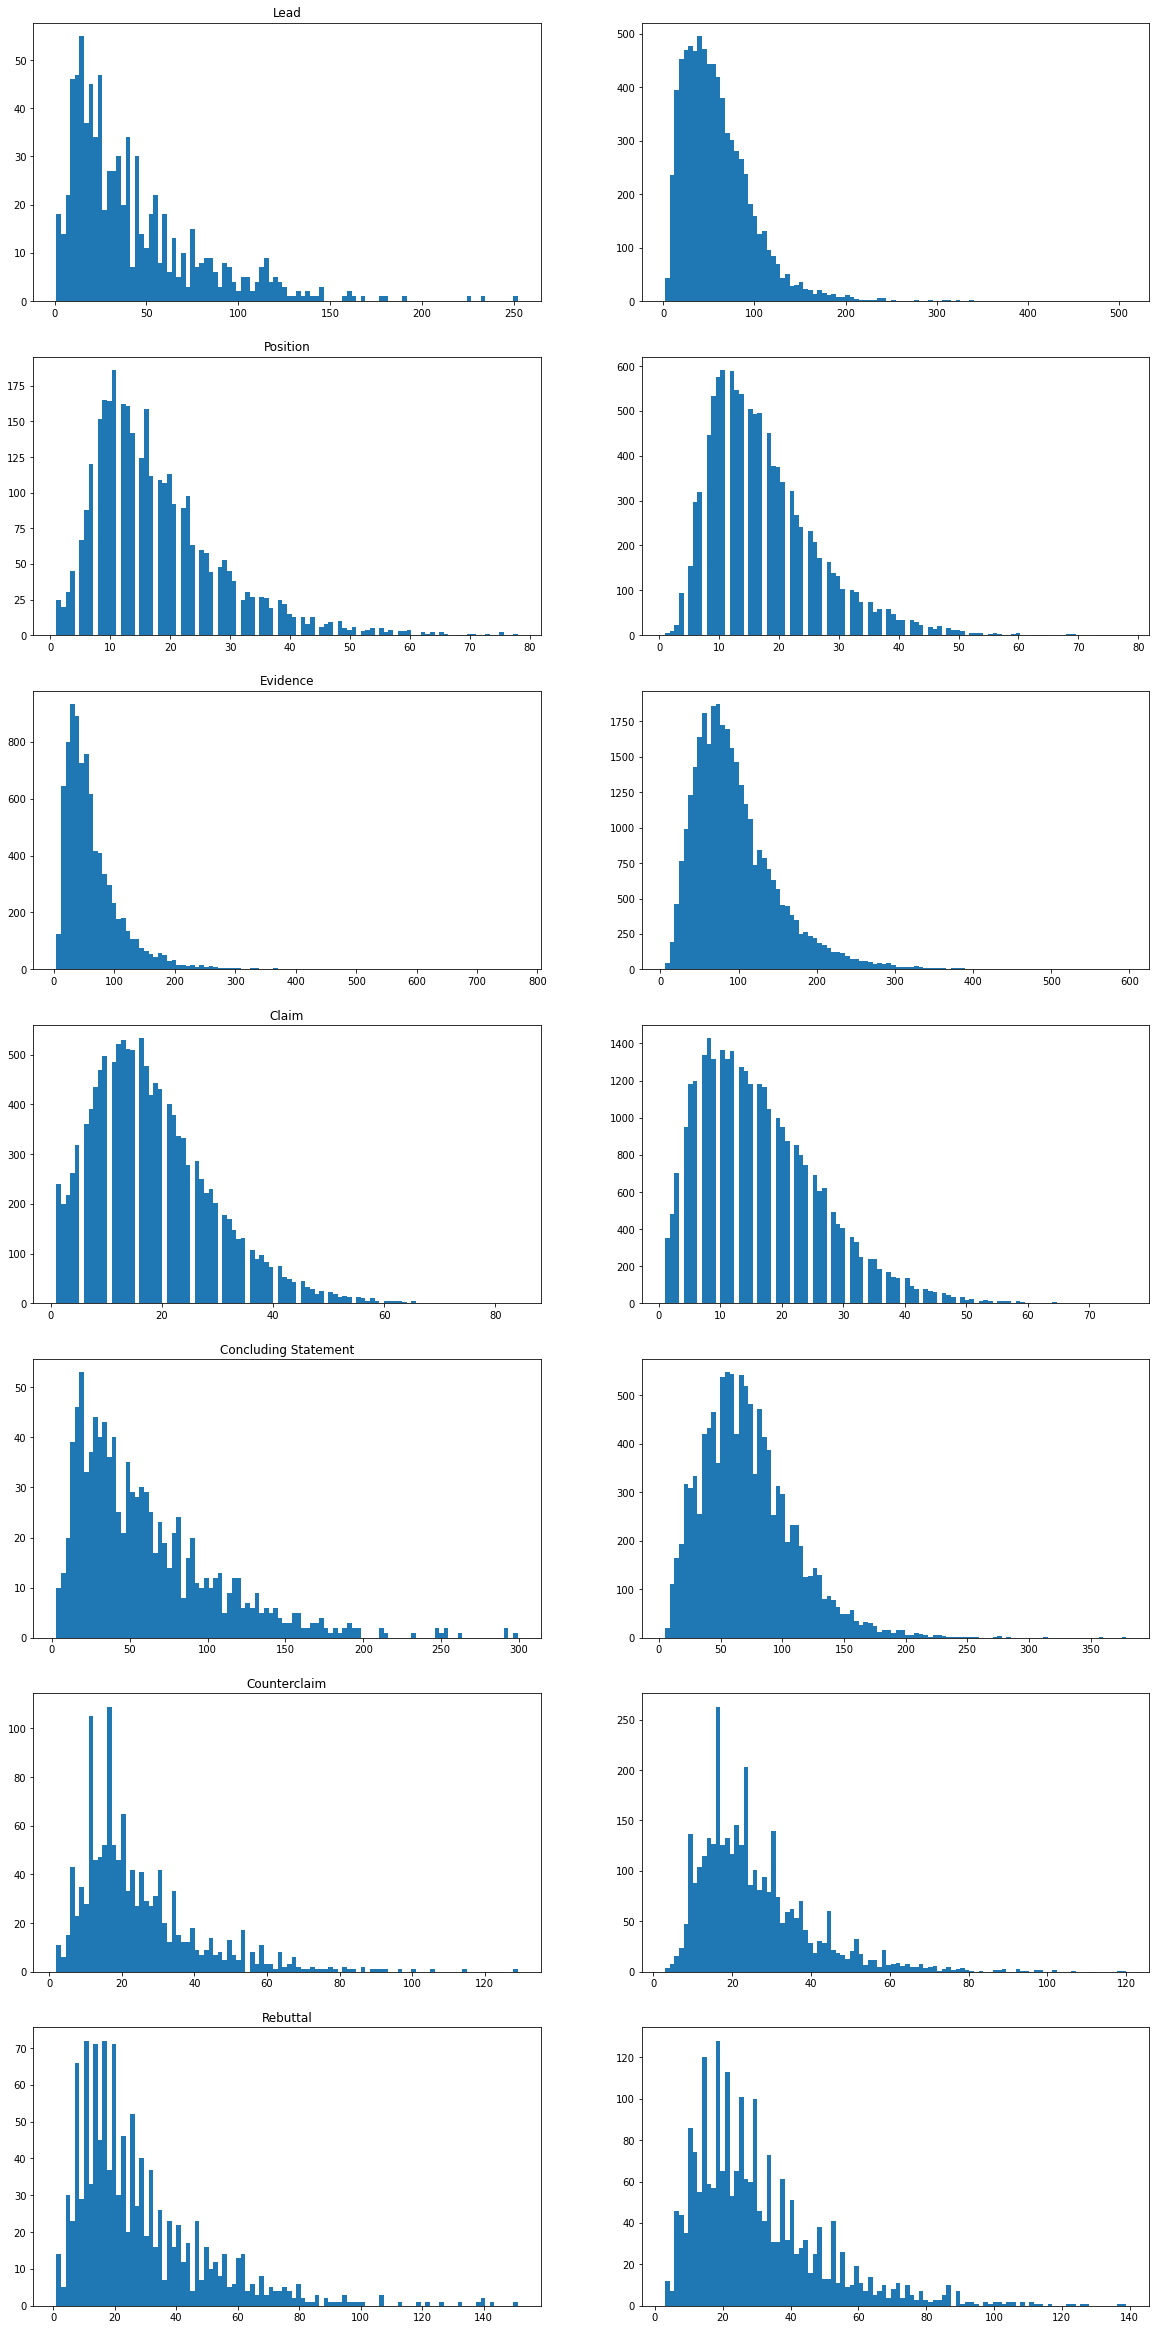

In [14]:
fig, axs = plt.subplots(7, 2, figsize=(20, 6 * 7))
for cat in range(1, 8):
    axs[cat-1, 0].set_title(label_names[cat])
    axs[cat - 1, 0].hist([x[1] - x[0] for k in all_mismatched_ps for x in all_mismatched_ps[k][cat]], 100)
    axs[cat - 1, 1].hist([x[1] - x[0] for k in all_mismatched_ps for x in all_matched_ps[k][cat]], 100)
